In [41]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import math
import re
from collections import defaultdict
from sklearn.model_selection import train_test_split
import seaborn as sb

In [2]:
df = pd.read_json('./data/train.json')

In [3]:
# unify street address
def street_name(add):
    add = add.title()
    words = add.split()
    # empty address
    if len(words) == 0:
        return ''
    # only one word street address
    if len(words) == 1:
        if (re.match("[W, E]-", words[0])):
            if re.match("W", words[0]):
                return 'West' + ' ' + re.findall('\d+', words[0])[0]
            if re.match("E", words[0]):
                return 'East' + ' ' + re.findall('\d+', words[0])[0]
        else:
            return words[0]
    # regular street address format start with number
    if re.match("^\d+", words[0]):
        words = words[1:]
    # parse street start with West or East
    if re.match("^[W, E, N][\.]?", words[0]) or re.match("West|East|North", words[0]):
        if re.match("^W[\.]?", words[0]):
            words[0] = 'West'
        if re.match("^E[\.]?", words[0]):
            words[0] = 'East'
        if re.match("^N[\.]?", words[0]):
            words[0] = 'North'
        if len(words) == 1:
            return words[0]
        if not re.match("\d+", words[1]):
            name = ''
            for w in words[0: 2]:
                if re.match("Av|St|Rd|Apt|Boul|Pl|Dr|Bl|Pk|Parkway|Road", w) or re.match("[#,\(,-]", w):
                    continue
                if w in num:
                    w = num[w]
                name += str(w) + ' '
            name = name.strip()
            return name
        return words[0] + ' ' + re.findall('\d+', words[1])[0]
    # parse street not start with West or East
    else:
        name = ''
        for i, w in enumerate(words[0: 2]):
            if i != 0 and (re.match("Av|St|Rd|Apt|Boul|Pl|Dr|Bl\.|Blvd|Parkway|Road|And", w) or re.match("[#,\(,-]", w)):
                continue
            if re.match("^\d", w):
                w = re.findall('\d+', w)[0]
            if w in num:
                w = num[w]
            name += str(w) + ' '
        name = name.strip()
        return name

In [4]:
num = {'First': 1, 'Second': 2, 'Third': 3, 'Fourth': 4, 'Fifth': 5, 'Sixth': 6, 'Seventh': 7, 'Eighth': 8, 'Ninth': 9, 'Tenth': 10}
level = {'low': 0, 'medium': 1, 'high': 2}
street = defaultdict(lambda: [0]*3)
count = 0
address = np.zeros(len(df['street_address']))
for pos, add in enumerate(df['street_address']):
    street[street_name(add)][level[df['interest_level'].iloc[pos]]] += 1

In [5]:
# compute global average
avg = 0
for pos, interest in enumerate(df['interest_level']):
    avg += level[interest]
avg /= len(df['interest_level'])
# compute street average
street_avg = {}
for s_name in street:
    l = street[s_name]
    street_avg[s_name] = (l[1] + l[2] * 2) / sum(l)

In [6]:
# predict using average for training set
error_avg = 0
error_street_avg = 0
for pos, add in enumerate(df['street_address']):
    y = level[df['interest_level'].iloc[pos]]
    if street_name(add) in street_avg:
        error_street_avg += abs(y - street_avg[street_name(add)])
    else:
        error_street_avg += abs(y - avg)
    error_avg += abs(y - avg)

print('simple avg: ') 
print(error_avg/len(df['street_address']))
print('street avg: ') 
print(error_street_avg/len(df['street_address']))

simple avg: 
0.5322731900288439
street avg: 
0.48239507742700594


In [7]:
import operator
street_size = {}
for n in street:
    street_size[n] = sum(street[n])
sorted_street_name = sorted(street_size.items(), key=operator.itemgetter(1), reverse=True)

low_count = 0
medium_count = 0
high_count = 0
for pos, interest in enumerate(df['interest_level']):
    if level[interest] == 0:
        low_count += 1
    if level[interest] == 1:
        medium_count += 1
    if level[interest] == 2:
        high_count += 1
low_ratio = [low_count/len(df['interest_level'])]
medium_ratio = [medium_count/len(df['interest_level'])]
high_ratio = [high_count/len(df['interest_level'])]
name = ['Training']
for (n, s) in sorted_street_name[:20]:
    l = street[n]
    name.append(n)
    low_ratio.append(l[0]/sum(l))
    medium_ratio.append(l[1]/sum(l))
    high_ratio.append(l[2]/sum(l))

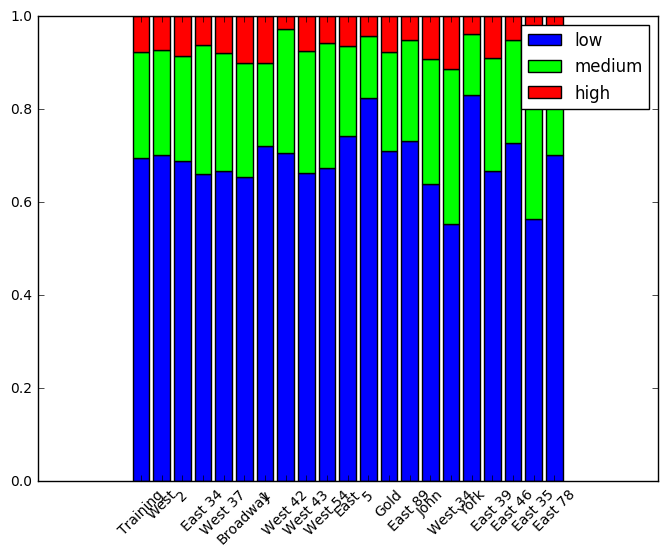

['Training', 'West', '2', 'East 34', 'West 37', 'Broadway', '1', 'West 42', 'West 43', 'West 54', 'East', '5', 'Gold', 'East 89', 'John', 'West 34', 'York', 'East 39', 'East 46', 'East 35', 'East 78']


In [31]:
# plot interest ratio for 20 streets with the largest number of listing items
fig = plt.figure(figsize=(8, 6))
ind = np.arange(len(low_ratio))
p_low = plt.bar(ind, low_ratio, width = 0.8, color = [0.0, 0.0, 1.0], align='center')
p_medium = plt.bar(ind, medium_ratio, width = 0.8, bottom = low_ratio, color = [0.0, 1.0, 0.0], align='center')
bot = []
for i in range(len(low_ratio)):
    bot.append(low_ratio[i]+medium_ratio[i])
p_high = plt.bar(ind, high_ratio, width = 0.8, bottom=bot, color = [1.0, 0.0, 0.0], align='center')
plt.legend((p_low[0], p_medium[0], p_high[0]), ('low', 'medium', 'high'))
plt.xticks(ind, name, rotation=45)
plt.show()
print(name)

In [32]:
# add address average to the data frame
address_feat = np.zeros(len(df['street_address']))
for pos, add in enumerate(df['street_address']):
    if street_name(add) in street_avg:
        address_feat[pos] = street_avg[street_name(add)]
    else:
        address_feat[pos] = avg
df['street_address_avg'] = address_feat

In [26]:
df.to_json('./data/train_address.json')

In [38]:
df = pd.read_json('./data/train_address.json')
df["num_photos"] = df["photos"].apply(len)
df["num_features"] = df["features"].apply(len)
df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
df["created"] = pd.to_datetime(df["created"])
df["created_year"] = df["created"].dt.year
df["created_month"] = df["created"].dt.month
df["created_day"] = df["created"].dt.day
df["bath_bed_sum"] = df['bathrooms'] + df['bedrooms']
df["bath_bed_diff"] = df['bathrooms'] - df['bedrooms']
df["price_per_bed"] = df['price'] / df['bedrooms']
df["price_per_bath"] = df['price'] / df['bathrooms']
df["price_per_room"] = df['price'] / df['bath_bed_sum']
features_to_use = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
                   "num_photos", "num_features", "num_description_words",
                   "created_year", "created_month", "created_day", "price_per_bed",
                   "price_per_bath", "price_per_room", "bath_bed_diff", "bath_bed_sum"]
features_to_use.append("street_address_avg")
X = df.drop(['interest_level'], axis = 1)
# X = df
y = df['interest_level']
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.33)
print(X_tr.reset_index().loc[1,:])

index                                                                17204
bathrooms                                                                1
bedrooms                                                                 3
building_id                               9ba2f2719b9ab170812a9ea79a3bd84c
created                                                2016-06-01 06:10:04
description              GORGEOUS 3 BR FLEX WITH FULL WALL IN THE HEART...
display_address                                                 N Moore St
features                 [Swimming Pool, Dining Room, Balcony, Elevator...
latitude                                                           40.7196
listing_id                                                         7093476
longitude                                                         -74.0109
manager_id                                5642b01c61afd6b54601365aedc96b68
photos                   [https://photos.renthop.com/2/7093476_5a2563c7...
price                    

In [40]:
# from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
features_selected = features_to_use

clf = XGBClassifier(objective='multi:softmax')
clf.fit(X_tr[features_selected] , y_tr)
log_proba_val = -np.log(clf.predict_proba(X_val[features_selected]))
onehot_val = pd.get_dummies(y_val).as_matrix().astype(np.bool_)
print('baseline with address', log_proba_val[onehot_val].mean())

baseline with address 0.636084


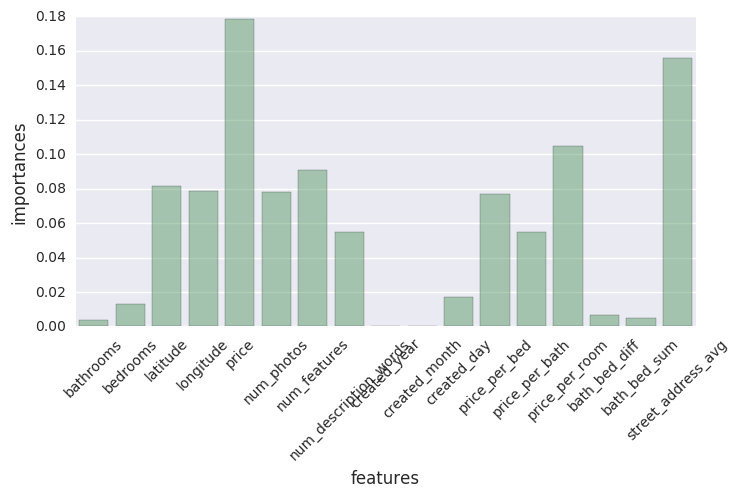

In [42]:
plt.figure(figsize=(8,4))
g = sb.barplot(features_selected, clf.feature_importances_, alpha=.5, color=sb.color_palette()[1])
plt.xticks(rotation=45)
plt.ylabel('importances', fontsize=12)
plt.xlabel('features', fontsize=12)
plt.savefig('xgboost_baseline.png')
plt.show()